In [1]:
import pandas as pd
import numpy as np
import pickle
from catboost import CatBoostClassifier
from sklearn.metrics import *
from matplotlib import pyplot as plt

In [2]:
pd.set_option("display.max_columns", None)

# 데이터

In [3]:
with open(f"./datasets/X_samples.pickle", "rb") as f:
    X_samples = pickle.load(f)
    
with open(f"./datasets/y_samples.pickle", "rb") as f:
    y_samples = pickle.load(f)
    
with open(f"./datasets/X_test.pickle", "rb") as f:
    X_test = pickle.load(f)
    
with open(f"./datasets/y_test.pickle", "rb") as f:
    y_test = pickle.load(f)

In [4]:
X_test.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
201810,0.579847,-0.011862,1.035499,-0.317540,0.216728,1.201270,-0.537323,1.319719,-0.189181,-0.627079,-0.131042,0.186976,0.428736,-0.650821,0.607427,-1.605008,-0.426110,-0.604022,0.099792,0.000011,-0.286629,0.166828,0.550873,-0.323683,-0.402491,0.195611,-0.573086,-0.079200,0.015847,-0.254035
264506,0.901937,2.267601,-1.634754,-2.368609,-2.592182,1.161092,3.434814,-1.615728,0.797080,-1.404452,1.591339,-0.219360,-0.722225,0.316331,-0.203926,0.188359,-0.707386,0.435844,-0.286008,-0.261407,-0.343678,-0.163936,-0.078568,0.259323,0.687408,-0.131926,-0.141368,0.026772,-0.055990,0.041920
63736,-0.397573,1.118301,-1.260762,0.981093,-0.380698,-1.876228,-0.490142,-1.089500,0.062601,0.119233,0.495179,-0.818852,-1.269072,-1.259742,-0.383677,0.541024,1.271092,0.402624,-0.814504,0.430227,0.227343,0.364685,0.773901,-0.193256,0.415118,0.360261,-0.054869,0.016690,0.043857,1.553832
241327,0.778757,2.063018,0.608260,-3.168853,0.618313,1.228515,-1.367266,0.683151,-0.308130,-0.147176,-0.859443,1.672501,0.060919,-0.917332,-2.099999,-0.637629,0.540038,1.976581,1.105321,-0.025014,-0.155587,-0.022321,0.076885,-0.042470,0.578092,0.345450,0.660782,-0.089294,-0.023863,-0.296793
271841,0.940836,-1.212528,0.730185,1.549615,-0.954037,0.008643,-0.092019,0.124386,0.595537,-0.570630,-1.090583,0.339272,0.843626,0.394601,0.266667,-0.512564,0.792514,-0.751414,0.277571,0.372448,-0.012042,-0.161695,-0.744489,-0.173554,-0.405409,0.217600,0.357895,-0.143519,-0.050795,0.034654


In [5]:
y_test.head()

201810    0
264506    0
63736     0
241327    0
271841    0
Name: Class, dtype: int64

In [6]:
for key, sample in X_samples.items():
    y = y_samples[key]
    total = len(y)
    counts = y.value_counts()
    
    print('=' * 100)
    print(key)
    print('=' * 100)
    print(sample.head())
    print('-' * 100)
    print(counts)
    print('-' * 30)
    print(f"Total : {total}")
    for idx in counts.index:
        print(f"{idx} 비율 : {counts[idx] / total * 100:6.2f} %")
    print('=' * 100)

Raw
            Time        V1        V2        V3        V4        V5        V6  \
143144  0.005428 -0.540939  0.637584  2.439590  1.316115  0.742650  1.671102   
258914  0.871545  1.923123 -1.555096  0.211476 -0.174906 -1.760650  0.456333   
51111  -0.468709 -1.939810 -1.039497  0.429346 -0.198014  2.693946 -2.792994   
146949  0.038652 -0.801246  1.067120  0.506310 -2.533708  0.597024 -1.446026   
135606 -0.039556 -0.280807  1.109719  0.944761 -0.132693  0.423860 -0.509289   

              V7        V8        V9       V10       V11       V12       V13  \
143144  0.280149  0.293844  0.026988 -0.120361 -1.040090  1.148056  1.069975   
258914 -1.652432  0.375407  0.892833  0.788104 -0.439165  0.143663 -1.216406   
51111  -0.279832  0.114651 -0.089721 -1.381296  0.012582 -0.794746 -1.833108   
146949  1.376331 -0.269470  0.208041 -0.934162 -0.882872  0.294591  0.305609   
135606  0.698370 -0.020385 -0.333794 -0.510310 -0.965409 -0.370223  0.236423   

             V14       V15       V

# CatBoost

In [7]:
def show_data_info(y):
    total = len(y)
    counts = y.value_counts()
    print('=' * 80)
    print(counts)
    print('-' * 30)
    for idx in counts.index:
        print(f"{idx} 비율 : {counts[idx] / total * 100:6.2f} %")
    print('=' * 80)

def evaluate_model(clf, x_test, y_test):
    y_proba = clf.predict_proba(x_test)
    y_pred = clf.predict(x_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    fl = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    
    print('=' * 80)
    print('Confusion Matrix')
    print(confusion_matrix(y_test, y_pred))
    print('-' * 60)
    print(f'Accuracy  : {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1-Score  : {fl}')
    print('-' * 60)
    print(classification_report(y_test,y_pred))
    print('-' * 60)
    print(f'ROC AUC : {roc_auc}')
    print('=' * 80)
    
    return accuracy, precision, recall, fl, roc_auc

In [8]:
clfs, results = {}, {}
accuracies, precisions, recalls, f1_scores, roc_aucs = {}, {}, {}, {}, {}

for key, X in X_samples.items():
    y = y_samples[key]
    
    print('=' * 80)
    print(key)
    show_data_info(y)
    
    clf = CatBoostClassifier(learning_rate=0.1, eval_metric='F1', early_stopping_rounds=100, verbose=False)
    clf.fit(X, y, eval_set=(X_test, y_test))
    
    print(f'CatBoost {key}')
    result = evaluate_model(clf, X_test, y_test)
    
    clfs[key] = clf
    results[key] = result

Raw
0    227447
1       398
Name: Class, dtype: int64
------------------------------
0 비율 :  99.83 %
1 비율 :   0.17 %
CatBoost Raw
Confusion Matrix
[[56866     2]
 [   25    69]]
------------------------------------------------------------
Accuracy  : 0.9995259997893332
Precision : 0.971830985915493
Recall    : 0.7340425531914894
F1-Score  : 0.8363636363636363
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56868
           1       0.97      0.73      0.84        94

    accuracy                           1.00     56962
   macro avg       0.99      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962

------------------------------------------------------------
ROC AUC : 0.9760256675032438
SMOTE
0    227447
1    227447
Name: Class, dtype: int64
------------------------------
0 비율 :  50.00 %
1 비율 :  50.00 %
CatBoost SMOTE
Confusion Matrix
[[56801  

In [9]:
class_weights = ['Balanced', 'SqrtBalanced']

for class_weight in class_weights:
    X, y = X_samples['Raw'], y_samples['Raw']
    
    print('=' * 80)
    print('Raw')
    show_data_info(y)
    
    clf = CatBoostClassifier(learning_rate=0.1, eval_metric='F1', auto_class_weights=class_weight,
                             early_stopping_rounds=100, verbose=False)
    clf.fit(X, y, eval_set=(X_test, y_test))
    
    print(f'CatBoost {class_weight}')
    result = evaluate_model(clf, X_test, y_test)
    
    clfs[class_weight] = clf
    results[class_weight] = result

Raw
0    227447
1       398
Name: Class, dtype: int64
------------------------------
0 비율 :  99.83 %
1 비율 :   0.17 %
CatBoost Balanced
Confusion Matrix
[[54916  1952]
 [   10    84]]
------------------------------------------------------------
Accuracy  : 0.9655559846915488
Precision : 0.0412573673870334
Recall    : 0.8936170212765957
F1-Score  : 0.07887323943661971
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56868
           1       0.04      0.89      0.08        94

    accuracy                           0.97     56962
   macro avg       0.52      0.93      0.53     56962
weighted avg       1.00      0.97      0.98     56962

------------------------------------------------------------
ROC AUC : 0.9691341015176618
Raw
0    227447
1       398
Name: Class, dtype: int64
------------------------------
0 비율 :  99.83 %
1 비율 :   0.17 %
CatBoost SqrtBalanced
Confusion Matr

In [14]:
cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC_AUC']
    
evaluation = pd.DataFrame(results, index=cols)
evaluation.index.set_names('Score', inplace=True)
evaluation

,Raw,SMOTE,ADASYN,CNN,SMOTE + ENN,ADASYN + ENN,Balanced,SqrtBalanced
Score,,,,,,,,
Accuracy,0.999526,0.998508,0.997876,0.999473,0.998332,0.998438,0.965556,0.999596
Precision,0.971831,0.531469,0.426230,0.863636,0.496815,0.516779,0.041257,0.927711
Recall,0.734043,0.808511,0.829787,0.808511,0.829787,0.819149,0.893617,0.819149
F1-Score,0.836364,0.641350,0.563177,0.835165,0.621514,0.633745,0.078873,0.870056
ROC_AUC,0.976026,0.976517,0.980706,0.977986,0.976670,0.976779,0.969134,0.983670


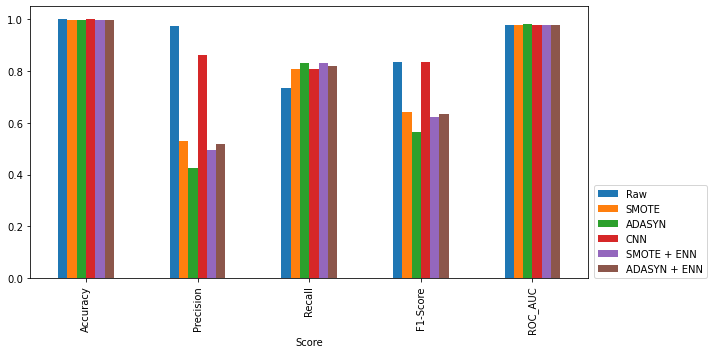

In [15]:
evaluation.plot(y=X_samples.keys(), kind="bar", figsize=(10, 5))
plt.legend(loc=(1.01, 0.))
plt.show()